**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

```
2022-08-27 08:00:29.172527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-27 08:00:29.172547: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
```
Try
```
conda install cudatoolkit
```

or

```
conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

```

In [1]:
import sys
sys.version_info

sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)

In [2]:
import tensorflow as tf
tf.__version__

2022-08-28 07:16:58.582104: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


'2.9.1'

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Perceptrons

**Note**: we set `max_iter` and `tol` explicitly to avoid warnings about the fact that their default value will change in future versions of Scikit-Learn.

In [4]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

/tmp/ipykernel_276709/3295362500.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris.target == 0).astype(np.int)


In [5]:
y_pred

array([1])

Saving figure perceptron_iris_plot


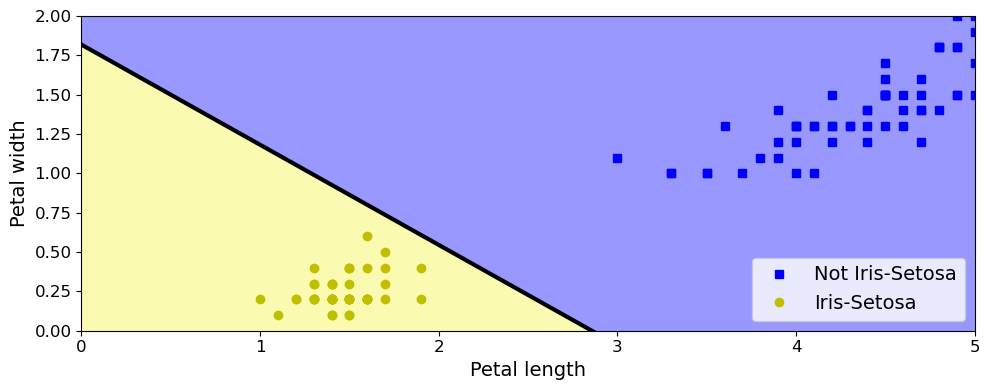

In [6]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# Activation functions

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


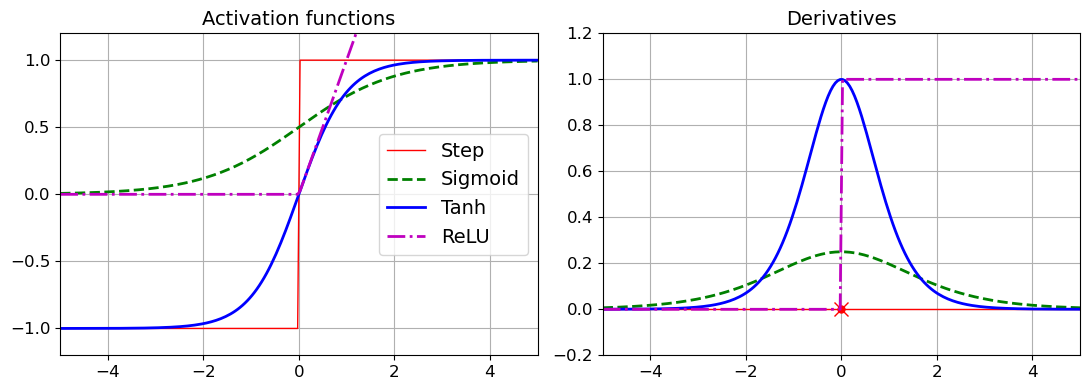

In [8]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

In [9]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

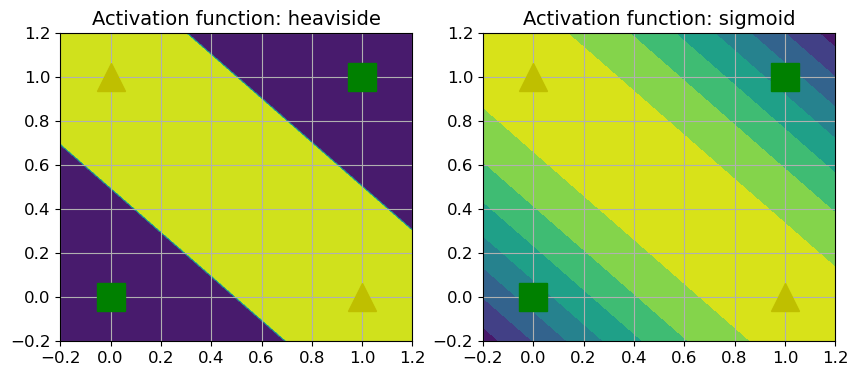

In [10]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [11]:
import tensorflow as tf
from tensorflow import keras

In [12]:
tf.__version__

'2.9.1'

```
keras.__version_
```
Gives:
```
ImportError: cannot import name 'dtensor' from 'tensorflow.compat.v2.experimental'
```
try:
```
pip install tensorflow==2.8
```

In [13]:
keras.__version__

'2.9.0'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [14]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [15]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [16]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [17]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

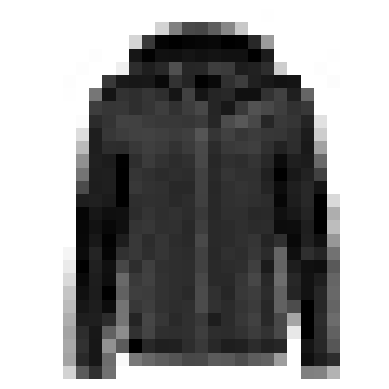

In [18]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [19]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [20]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [21]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [22]:
X_valid.shape

(5000, 28, 28)

In [23]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


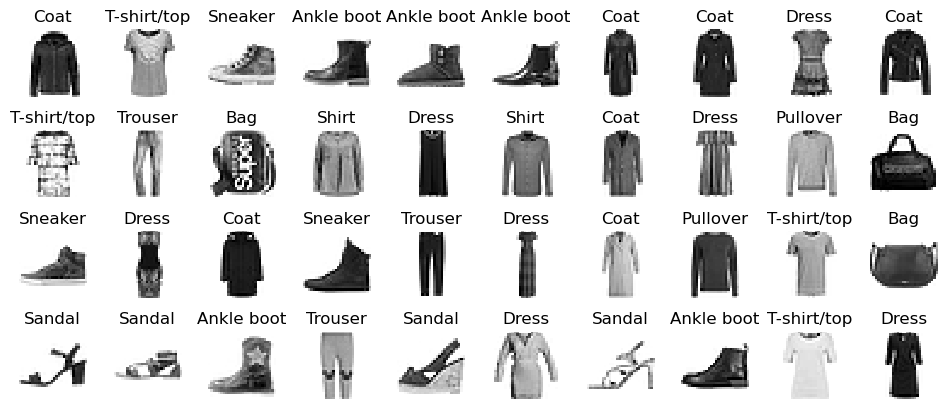

In [24]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [25]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

2022-08-28 07:17:20.782517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 07:17:20.786219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 07:17:20.786314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 07:17:20.786834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [26]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [28]:
model.layers

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


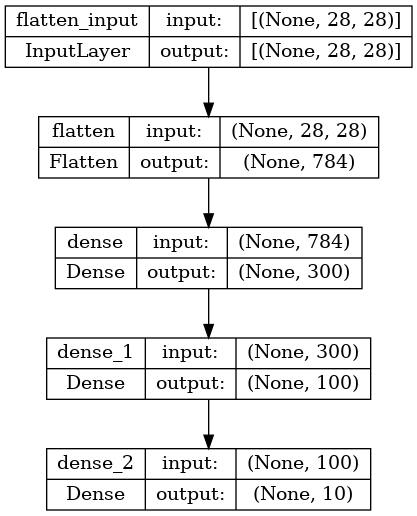

In [30]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [31]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [32]:
model.get_layer(hidden1.name) is hidden1

True

In [33]:
weights, biases = hidden1.get_weights()

In [34]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [35]:
weights.shape

(784, 300)

In [36]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [37]:
biases.shape

(300,)

In [38]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [39]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
  58/1719 [>.............................] - ETA: 1s - loss: 1.9654 - accuracy: 0.3869   

2022-08-28 07:17:31.391591: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1719/1719 [==============================] - 2s 915us/step - loss: 0.7237 - accuracy: 0.7644 - val_loss: 0.5201 - val_accuracy: 0.8230
Epoch 2/30
1719/1719 [==============================] - 1s 860us/step - loss: 0.4844 - accuracy: 0.8320 - val_loss: 0.4345 - val_accuracy: 0.8534
Epoch 3/30
1719/1719 [==============================] - 1s 863us/step - loss: 0.4390 - accuracy: 0.8456 - val_loss: 0.5350 - val_accuracy: 0.7978
Epoch 4/30
1719/1719 [==============================] - 1s 862us/step - loss: 0.4121 - accuracy: 0.8567 - val_loss: 0.3910 - val_accuracy: 0.8652
Epoch 5/30
1719/1719 [==============================] - 1s 861us/step - loss: 0.3938 - accuracy: 0.8620 - val_loss: 0.3745 - val_accuracy: 0.8698
Epoch 6/30
1719/1719 [==============================] - 1s 861us/step - loss: 0.3752 - accuracy: 0.8678 - val_loss: 0.3723 - val_accuracy: 0.8724
Epoch 7/30
1719/1719 [==============================] - 1s 866us/step - loss: 0.3634 - accuracy: 0.8711 - val_loss: 0.3618 - val_accura

In [40]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [41]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [43]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


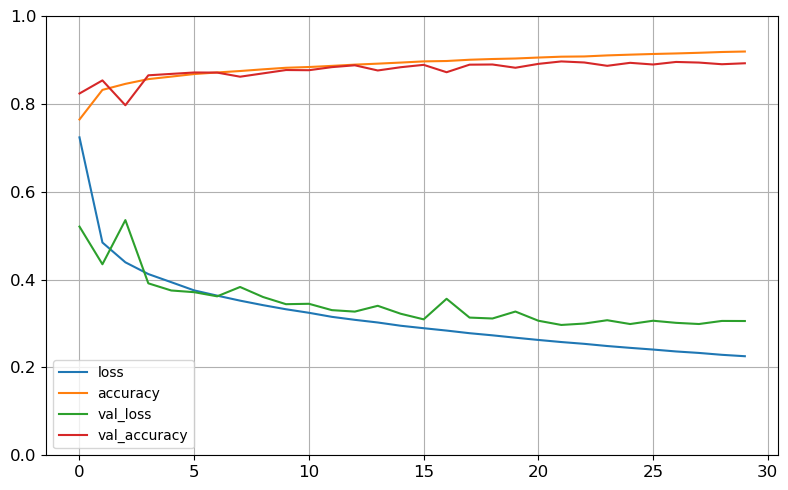

In [44]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [45]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 593us/step - loss: 0.3395 - accuracy: 0.8828


[0.33954301476478577, 0.8827999830245972]

In [46]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 65ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

**Warning**: `model.predict_classes(X_new)` is deprecated. It is replaced with `np.argmax(model.predict(X_new), axis=-1)`.

In [47]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 [==============================] - 0s 24ms/step


array([9, 2, 1])

In [48]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [49]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


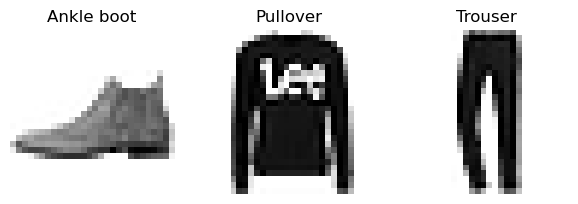

In [50]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [51]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [52]:
np.random.seed(42)
tf.random.set_seed(42)

In [53]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 0s 697us/step - loss: 1.6419 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 0s 485us/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 0s 499us/step - loss: 0.6345 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 0s 496us/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 0s 493us/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 0s 486us/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 0s 486us/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 0s 499us/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 0s 497us/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 0s 486us/step - loss: 0.487

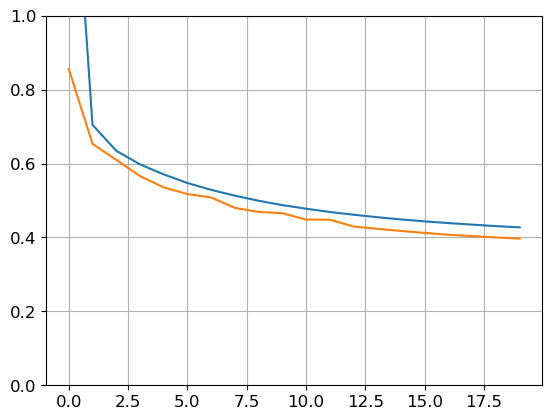

In [54]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [55]:
y_pred

array([[0.3885664],
       [1.6792021],
       [3.1022797]], dtype=float32)

# Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [56]:
np.random.seed(42)
tf.random.set_seed(42)

In [57]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [58]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 30)           270         ['input_1[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 30)           930         ['dense_5[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 38)           0           ['input_1[0][0]',                
                                                                  'dense_6[0][0]']            

In [59]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 0s 774us/step - loss: 1.2611 - val_loss: 3.3940
Epoch 2/20
363/363 [==============================] - 0s 544us/step - loss: 0.6580 - val_loss: 0.9360
Epoch 3/20
363/363 [==============================] - 0s 522us/step - loss: 0.5878 - val_loss: 0.5649
Epoch 4/20
363/363 [==============================] - 0s 531us/step - loss: 0.5582 - val_loss: 0.5712
Epoch 5/20
363/363 [==============================] - 0s 528us/step - loss: 0.5347 - val_loss: 0.5045
Epoch 6/20
363/363 [==============================] - 0s 530us/step - loss: 0.5158 - val_loss: 0.4831
Epoch 7/20
363/363 [==============================] - 0s 532us/step - loss: 0.5002 - val_loss: 0.4639
Epoch 8/20
363/363 [==============================] - 0s 516us/step - loss: 0.4876 - val_loss: 0.4638
Epoch 9/20
363/363 [==============================] - 0s 536us/step - loss: 0.4760 - val_loss: 0.4421
Epoch 10/20
363/363 [==============================] - 0s 526us/step - loss: 0.465

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [60]:
np.random.seed(42)
tf.random.set_seed(42)

In [61]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [62]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 0s 789us/step - loss: 1.8145 - val_loss: 0.8072
Epoch 2/20
363/363 [==============================] - 0s 554us/step - loss: 0.6771 - val_loss: 0.6658
Epoch 3/20
363/363 [==============================] - 0s 582us/step - loss: 0.5979 - val_loss: 0.5687
Epoch 4/20
363/363 [==============================] - 0s 565us/step - loss: 0.5584 - val_loss: 0.5296
Epoch 5/20
363/363 [==============================] - 0s 572us/step - loss: 0.5334 - val_loss: 0.4993
Epoch 6/20
363/363 [==============================] - 0s 579us/step - loss: 0.5120 - val_loss: 0.4811
Epoch 7/20
363/363 [==============================] - 0s 567us/step - loss: 0.4970 - val_loss: 0.4696
Epoch 8/20
363/363 [==============================] - 0s 561us/step - loss: 0.4843 - val_loss: 0.4496
Epoch 9/20
363/363 [==============================] - 0s 579us/step - loss: 0.4730 - val_loss: 0.4404
Epoch 10/20
363/363 [==============================] - 0s 568us/step - loss: 0.464

Adding an auxiliary output for regularization:

In [63]:
np.random.seed(42)
tf.random.set_seed(42)

In [64]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [65]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [66]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 1s 870us/step - loss: 2.1365 - main_output_loss: 1.9196 - aux_output_loss: 4.0890 - val_loss: 1.6233 - val_main_output_loss: 0.8468 - val_aux_output_loss: 8.6117
Epoch 2/20
363/363 [==============================] - 0s 654us/step - loss: 0.8905 - main_output_loss: 0.6969 - aux_output_loss: 2.6326 - val_loss: 1.5163 - val_main_output_loss: 0.6836 - val_aux_output_loss: 9.0109
Epoch 3/20
363/363 [==============================] - 0s 655us/step - loss: 0.7429 - main_output_loss: 0.6088 - aux_output_loss: 1.9499 - val_loss: 1.4639 - val_main_output_loss: 0.6229 - val_aux_output_loss: 9.0326
Epoch 4/20
363/363 [==============================] - 0s 673us/step - loss: 0.6771 - main_output_loss: 0.5691 - aux_output_loss: 1.6485 - val_loss: 1.3388 - val_main_output_loss: 0.5481 - val_aux_output_loss: 8.4552
Epoch 5/20
363/363 [==============================] - 0s 652us/step - loss: 0.6381 - main_output_loss: 0.5434 - aux_output_loss: 1.4911 

In [67]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

1/1 [==============================] - 0s 33ms/step


# The subclassing API

In [68]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [69]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 1s 945us/step - loss: 2.3298 - output_1_loss: 2.2186 - output_2_loss: 3.3304 - val_loss: 2.1435 - val_output_1_loss: 1.1581 - val_output_2_loss: 11.0117
Epoch 2/10
363/363 [==============================] - 0s 652us/step - loss: 0.9714 - output_1_loss: 0.8543 - output_2_loss: 2.0252 - val_loss: 1.7567 - val_output_1_loss: 0.8205 - val_output_2_loss: 10.1825
Epoch 3/10
363/363 [==============================] - 0s 658us/step - loss: 0.8268 - output_1_loss: 0.7289 - output_2_loss: 1.7082 - val_loss: 1.5664 - val_output_1_loss: 0.7913 - val_output_2_loss: 8.5419
Epoch 4/10
363/363 [==============================] - 0s 634us/step - loss: 0.7636 - output_1_loss: 0.6764 - output_2_loss: 1.5477 - val_loss: 1.3088 - val_output_1_loss: 0.6549 - val_output_2_loss: 7.1933
Epoch 5/10
363/363 [==============================] - 0s 632us/step - loss: 0.7211 - output_1_loss: 0.6402 - output_2_loss: 1.4489 - val_loss: 1.1357 - val_output_1_loss: 0.5

# Saving and Restoring

In [70]:
np.random.seed(42)
tf.random.set_seed(42)

In [71]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [72]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 0s 716us/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 500us/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 534us/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 529us/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 514us/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 501us/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 507us/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 514us/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 498us/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 345us/step - loss: 0.438

In [73]:
model.save("my_keras_model.h5")

In [74]:
model = keras.models.load_model("my_keras_model.h5")

In [75]:
model.predict(X_new)

1/1 [==============================] - 0s 22ms/step


array([[0.5400235],
       [1.6505971],
       [3.009824 ]], dtype=float32)

In [76]:
model.save_weights("my_keras_weights.ckpt")

In [77]:
model.load_weights("my_keras_weights.ckpt")

# Using Callbacks during Training

In [78]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [79]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [80]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 0s 697us/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 501us/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 521us/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 522us/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 522us/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 510us/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 524us/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 529us/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 532us/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 369us/step - loss: 0.438

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 0s 708us/step - loss: 0.4393 - val_loss: 0.4110
Epoch 2/100
363/363 [==============================] - 0s 513us/step - loss: 0.4315 - val_loss: 0.4266
Epoch 3/100
363/363 [==============================] - 0s 523us/step - loss: 0.4259 - val_loss: 0.3996
Epoch 4/100
363/363 [==============================] - 0s 537us/step - loss: 0.4201 - val_loss: 0.3939
Epoch 5/100
363/363 [==============================] - 0s 511us/step - loss: 0.4154 - val_loss: 0.3889
Epoch 6/100
363/363 [==============================] - 0s 525us/step - loss: 0.4111 - val_loss: 0.3866
Epoch 7/100
363/363 [==============================] - 0s 527us/step - loss: 0.4074 - val_loss: 0.3860
Epoch 8/100
363/363 [==============================] - 0s 549us/step - loss: 0.4040 - val_loss: 0.3793
Epoch 9/100
363/363 [==============================] - 0s 533us/step - loss: 0.4008 - val_loss: 0.3746
Epoch 10/100
363/363 [==============================] - 0s 515us/step - l

In [ ]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [ ]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

# TensorBoard

In [89]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [90]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2022_08_27-10_08_01'

In [91]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [92]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [93]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 0s 834us/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/30
363/363 [==============================] - 0s 710us/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/30
363/363 [==============================] - 0s 708us/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/30
363/363 [==============================] - 0s 707us/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/30
363/363 [==============================] - 0s 702us/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/30
363/363 [==============================] - 0s 700us/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/30
363/363 [==============================] - 0s 694us/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/30
363/363 [==============================] - 0s 701us/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/30
363/363 [==============================] - 0s 708us/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/30
363/363 [==============================] - 0s 707us/step - loss: 0.447

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [94]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

/home/arvid/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/home/arvid/anaconda3/envs/tf-gpu/bin/tensorboard", line 6, in <module>
    from tensorboard.main import run_main
  File "/home/arvid/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/tensorboard/main.py", line 27, in <module>
    from tensorboard import default
  File "/home/arvid/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/tensorboard/default.py", line 33, in <module>
    from tensorboard.plugins.audio import audio_plugin
  File "/home/arvid/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/tensorboard/plugins/audio/audio_plugin.py", line 23, in <module>
    from tensorboard import plugin_util
  File "/home/arvid/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/tensorboard/plugin_util.py", line 20, in <module>
    from tensorboard._vendor.bleach.sanitizer import Cleaner
  File "/home/arvid/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/tensorboard/_vendor

In [96]:
run_logdir2 = get_run_logdir()
run_logdir2

'./my_logs/run_2022_08_27-10_08_38'

In [97]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [98]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.05))

In [99]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 0s 850us/step - loss: 0.5530 - val_loss: 302.8540
Epoch 2/30
363/363 [==============================] - 0s 718us/step - loss: 91.3574 - val_loss: 1.3182
Epoch 3/30
363/363 [==============================] - 0s 717us/step - loss: 1.3409 - val_loss: 1.3054
Epoch 4/30
363/363 [==============================] - 0s 707us/step - loss: 1.2928 - val_loss: 1.2537
Epoch 5/30
363/363 [==============================] - 0s 711us/step - loss: 1.1917 - val_loss: 1.1301
Epoch 6/30
363/363 [==============================] - 0s 714us/step - loss: 1.1619 - val_loss: 1.1215
Epoch 7/30
363/363 [==============================] - 0s 724us/step - loss: 1.1503 - val_loss: 1.0895
Epoch 8/30
363/363 [==============================] - 0s 722us/step - loss: 1.1729 - val_loss: 1.1171
Epoch 9/30
363/363 [==============================] - 0s 733us/step - loss: 1.1351 - val_loss: 1.1395
Epoch 10/30
363/363 [==============================] - 0s 717us/step - loss: 1.

Notice how TensorBoard now sees two runs, and you can compare the learning curves.

Check out the other available logging options:

In [100]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, write_steps_per_second=False, update_freq='epoch', profile_batch=0, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# Hyperparameter Tuning

In [101]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [102]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [103]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

/tmp/ipykernel_137737/1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [104]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 0s 762us/step - loss: 1.0896 - val_loss: 20.7721
Epoch 2/100
363/363 [==============================] - 0s 667us/step - loss: 0.7606 - val_loss: 5.0266
Epoch 3/100
363/363 [==============================] - 0s 661us/step - loss: 0.5456 - val_loss: 0.5490
Epoch 4/100
363/363 [==============================] - 0s 675us/step - loss: 0.4732 - val_loss: 0.4529
Epoch 5/100
363/363 [==============================] - 0s 671us/step - loss: 0.4503 - val_loss: 0.4188
Epoch 6/100
363/363 [==============================] - 0s 659us/step - loss: 0.4338 - val_loss: 0.4129
Epoch 7/100
363/363 [==============================] - 0s 655us/step - loss: 0.4241 - val_loss: 0.4004
Epoch 8/100
363/363 [==============================] - 0s 662us/step - loss: 0.4168 - val_loss: 0.3944
Epoch 9/100
363/363 [==============================] - 0s 666us/step - loss: 0.4108 - val_loss: 0.3961
Epoch 10/100
363/363 [==============================] - 0s 678us/step - 

Epoch 80/100
363/363 [==============================] - 0s 700us/step - loss: 0.3376 - val_loss: 0.3605
Epoch 81/100
363/363 [==============================] - 0s 688us/step - loss: 0.3384 - val_loss: 0.3438
Epoch 82/100
363/363 [==============================] - 0s 671us/step - loss: 0.3371 - val_loss: 0.3226
Epoch 83/100
363/363 [==============================] - 0s 695us/step - loss: 0.3368 - val_loss: 0.3295
Epoch 84/100
363/363 [==============================] - 0s 679us/step - loss: 0.3362 - val_loss: 0.4067
Epoch 85/100
363/363 [==============================] - 0s 701us/step - loss: 0.3369 - val_loss: 0.3278
Epoch 86/100
363/363 [==============================] - 0s 675us/step - loss: 0.3359 - val_loss: 0.3398
Epoch 87/100
363/363 [==============================] - 0s 672us/step - loss: 0.3356 - val_loss: 0.3806
Epoch 88/100
363/363 [==============================] - 0s 664us/step - loss: 0.3358 - val_loss: 0.3223
Epoch 89/100
363/363 [==============================] - 0s 678us

In [109]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 422us/step - loss: 0.3483


In [110]:
mse_test

-0.348263680934906

In [111]:
y_pred = keras_reg.predict(X_new)

In [112]:
np.random.seed(42)
tf.random.set_seed(42)

**Warning**: the following cell crashes at the end of training. This seems to be caused by [Keras issue #13586](https://github.com/keras-team/keras/issues/13586), which was triggered by a recent change in Scikit-Learn. [Pull Request #13598](https://github.com/keras-team/keras/pull/13598) seems to fix the issue, so this problem should be resolved soon. In the meantime, I've added `.tolist()` and `.rvs(1000).tolist()` as workarounds.

In [113]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100)               .tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2)      .rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
242/242 [==============================] - 0s 927us/step - loss: 0.8420 - val_loss: 0.4703
Epoch 2/100
242/242 [==============================] - 0s 733us/step - loss: 0.4815 - val_loss: 0.4247
Epoch 3/100
242/242 [==============================] - 0s 730us/step - loss: 0.4519 - val_loss: 0.4052
Epoch 4/100
242/242 [==============================] - 0s 729us/step - loss: 0.4429 - val_loss: 0.3975
Epoch 5/100
242/242 [==============================] - 0s 727us/step - loss: 0.4368 - val_loss: 0.3991
Epoch 6/100
242/242 [==============================] - 0s 751us/step - loss: 0.4340 - val_loss: 0.4031
Epoch 7/100
242/242 [==============================] - 0s 737us/step - loss: 0.4351 - val_loss: 0.4043
Epoch 8/100
242/242 [==============================] - 0s 734us/step - loss: 0.4267 - val_loss: 0.3929
Epoch 9/100
242/242 [==============================] - 0s 768us/step - loss: 0.4258 - val_loss: 0.4040
Epoch 10/100

Epoch 24/100
242/242 [==============================] - 0s 755us/step - loss: 0.5671 - val_loss: 0.5266
Epoch 25/100
242/242 [==============================] - 0s 743us/step - loss: 0.5614 - val_loss: 0.5214
Epoch 26/100
242/242 [==============================] - 0s 752us/step - loss: 0.5558 - val_loss: 0.5166
Epoch 27/100
242/242 [==============================] - 0s 744us/step - loss: 0.5504 - val_loss: 0.5116
Epoch 28/100
242/242 [==============================] - 0s 757us/step - loss: 0.5453 - val_loss: 0.5076
Epoch 29/100
242/242 [==============================] - 0s 735us/step - loss: 0.5403 - val_loss: 0.5035
Epoch 30/100
242/242 [==============================] - 0s 750us/step - loss: 0.5356 - val_loss: 0.4989
Epoch 31/100
242/242 [==============================] - 0s 758us/step - loss: 0.5309 - val_loss: 0.4946
Epoch 32/100
242/242 [==============================] - 0s 764us/step - loss: 0.5265 - val_loss: 0.4915
Epoch 33/100
242/242 [==============================] - 0s 725us

242/242 [==============================] - 0s 741us/step - loss: 0.4764 - val_loss: 0.4525
Epoch 50/100
242/242 [==============================] - 0s 749us/step - loss: 0.4740 - val_loss: 0.4495
Epoch 51/100
242/242 [==============================] - 0s 724us/step - loss: 0.4716 - val_loss: 0.4468
Epoch 52/100
242/242 [==============================] - 0s 739us/step - loss: 0.4693 - val_loss: 0.4446
Epoch 53/100
242/242 [==============================] - 0s 737us/step - loss: 0.4670 - val_loss: 0.4420
Epoch 54/100
242/242 [==============================] - 0s 729us/step - loss: 0.4649 - val_loss: 0.4394
Epoch 55/100
242/242 [==============================] - 0s 725us/step - loss: 0.4628 - val_loss: 0.4373
Epoch 56/100
242/242 [==============================] - 0s 734us/step - loss: 0.4607 - val_loss: 0.4349
Epoch 57/100
242/242 [==============================] - 0s 736us/step - loss: 0.4588 - val_loss: 0.4330
Epoch 58/100
242/242 [==============================] - 0s 730us/step - loss:

Epoch 8/100
242/242 [==============================] - 0s 779us/step - loss: 0.4633 - val_loss: 0.4297
Epoch 9/100
242/242 [==============================] - 0s 779us/step - loss: 0.4483 - val_loss: 0.4464
Epoch 10/100
242/242 [==============================] - 0s 783us/step - loss: 0.4374 - val_loss: 0.4189
Epoch 11/100
242/242 [==============================] - 0s 793us/step - loss: 0.4266 - val_loss: 0.4438
Epoch 12/100
242/242 [==============================] - 0s 780us/step - loss: 0.4188 - val_loss: 0.4250
Epoch 13/100
242/242 [==============================] - 0s 785us/step - loss: 0.4121 - val_loss: 0.4009
Epoch 14/100
242/242 [==============================] - 0s 788us/step - loss: 0.4067 - val_loss: 0.4403
Epoch 15/100
242/242 [==============================] - 0s 779us/step - loss: 0.4025 - val_loss: 0.4014
Epoch 16/100
242/242 [==============================] - 0s 782us/step - loss: 0.3981 - val_loss: 0.4247
Epoch 17/100
242/242 [==============================] - 0s 777us/s

242/242 [==============================] - 0s 681us/step - loss: 1.4803 - val_loss: 216.7263
Epoch 11/100
242/242 [==============================] - 0s 710us/step - loss: 13.8365 - val_loss: 125.2063
Epoch 12/100
242/242 [==============================] - 0s 686us/step - loss: 0.6450 - val_loss: 2.2902
Epoch 13/100
242/242 [==============================] - 0s 674us/step - loss: 0.7449 - val_loss: 790.5418
Epoch 14/100
242/242 [==============================] - 0s 677us/step - loss: 9.2398 - val_loss: 468.7421
Epoch 15/100
242/242 [==============================] - 0s 688us/step - loss: 2.2300 - val_loss: 1073.9144
Epoch 16/100
242/242 [==============================] - 0s 679us/step - loss: 37.3800 - val_loss: 865.6371
Epoch 17/100
242/242 [==============================] - 0s 681us/step - loss: 8.9708 - val_loss: 1128.1489
Epoch 18/100
242/242 [==============================] - 0s 676us/step - loss: 3.8291 - val_loss: 499.5186
Epoch 19/100
242/242 [==============================] - 0

242/242 [==============================] - 0s 734us/step - loss: 0.3779 - val_loss: 0.4403
Epoch 39/100
242/242 [==============================] - 0s 746us/step - loss: 0.3769 - val_loss: 0.3551
Epoch 40/100
242/242 [==============================] - 0s 738us/step - loss: 0.3757 - val_loss: 0.4125
Epoch 41/100
242/242 [==============================] - 0s 730us/step - loss: 0.3748 - val_loss: 0.3665
Epoch 42/100
242/242 [==============================] - 0s 738us/step - loss: 0.3735 - val_loss: 0.3591
Epoch 43/100
242/242 [==============================] - 0s 726us/step - loss: 0.3730 - val_loss: 0.3570
Epoch 44/100
242/242 [==============================] - 0s 722us/step - loss: 0.3717 - val_loss: 0.4125
Epoch 45/100
242/242 [==============================] - 0s 723us/step - loss: 0.3714 - val_loss: 0.3547
Epoch 46/100
242/242 [==============================] - 0s 741us/step - loss: 0.3699 - val_loss: 0.3779
Epoch 47/100
121/121 [==============================] - 0s 432us/step - loss:

Epoch 8/100
242/242 [==============================] - 0s 841us/step - loss: 0.3569 - val_loss: 0.3384
Epoch 9/100
242/242 [==============================] - 0s 848us/step - loss: 0.3518 - val_loss: 0.3720
Epoch 10/100
242/242 [==============================] - 0s 846us/step - loss: 0.3514 - val_loss: 0.3274
Epoch 11/100
242/242 [==============================] - 0s 835us/step - loss: 0.3456 - val_loss: 0.3958
Epoch 12/100
242/242 [==============================] - 0s 829us/step - loss: 0.3419 - val_loss: 0.3324
Epoch 13/100
242/242 [==============================] - 0s 832us/step - loss: 0.3372 - val_loss: 0.3226
Epoch 14/100
242/242 [==============================] - 0s 848us/step - loss: 0.3346 - val_loss: 0.3680
Epoch 15/100
242/242 [==============================] - 0s 835us/step - loss: 0.3323 - val_loss: 0.3212
Epoch 16/100
242/242 [==============================] - 0s 852us/step - loss: 0.3295 - val_loss: 0.3530
Epoch 17/100
242/242 [==============================] - 0s 833us/s

Epoch 1/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8381 - val_loss: 0.6551
Epoch 2/100
242/242 [==============================] - 0s 831us/step - loss: 0.4570 - val_loss: 0.4129
Epoch 3/100
242/242 [==============================] - 0s 838us/step - loss: 0.4107 - val_loss: 0.6096
Epoch 4/100
242/242 [==============================] - 0s 847us/step - loss: 0.3911 - val_loss: 0.6534
Epoch 5/100
242/242 [==============================] - 0s 830us/step - loss: 0.3755 - val_loss: 0.6227
Epoch 6/100
242/242 [==============================] - 0s 832us/step - loss: 0.3647 - val_loss: 0.8403
Epoch 7/100
242/242 [==============================] - 0s 837us/step - loss: 0.3602 - val_loss: 1.0599
Epoch 8/100
242/242 [==============================] - 0s 851us/step - loss: 0.3516 - val_loss: 1.1357
Epoch 9/100
242/242 [==============================] - 0s 854us/step - loss: 0.3456 - val_loss: 1.2306
Epoch 10/100
242/242 [==============================] - 0s 845us/step - los

242/242 [==============================] - 0s 794us/step - loss: 0.2918 - val_loss: 0.3018
Epoch 74/100
242/242 [==============================] - 0s 805us/step - loss: 0.2897 - val_loss: 0.3779
Epoch 75/100
242/242 [==============================] - 0s 783us/step - loss: 0.2910 - val_loss: 0.3002
Epoch 76/100
242/242 [==============================] - 0s 781us/step - loss: 0.2893 - val_loss: 0.3228
Epoch 77/100
242/242 [==============================] - 0s 767us/step - loss: 0.2928 - val_loss: 0.3899
Epoch 78/100
242/242 [==============================] - 0s 771us/step - loss: 0.2901 - val_loss: 0.8437
Epoch 79/100
242/242 [==============================] - 0s 778us/step - loss: 0.2938 - val_loss: 0.4616
Epoch 80/100
121/121 [==============================] - 0s 432us/step - loss: 0.3241
[CV] END learning_rate=0.004591455636549438, n_hidden=2, n_neurons=59; total time=  15.5s
Epoch 1/100
242/242 [==============================] - 0s 966us/step - loss: 1.1975 - val_loss: 0.8898
Epoch 2

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f1327bc8cd0>,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.0003920021771415983,
                                                          0.01619845322936229,
                                                          0.004779156784872302,
                                                          0.007821074275112298,...
                                                          0.005021425736625637,
                                                          0.0005703073595961105,
                                                          0.001151888789941251,
                                                          0.001621231156394198,
                                                          0.0024505367684280487,
                                                          0.011155092541719619,
                                                          0.0007524347058135697,
                                                          0.0032032448128444043,
                                                          0.004591455636549438,
                                                          0.0003715541189658278, ...],
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...]},
                   verbose=2)

In [114]:
rnd_search_cv.best_params_

{'n_neurons': 74, 'n_hidden': 3, 'learning_rate': 0.005803602934201024}

In [115]:
rnd_search_cv.best_score_

-0.32262249787648517

In [116]:
rnd_search_cv.best_estimator_

In [117]:
rnd_search_cv.score(X_test, y_test)

162/162 [==============================] - 0s 477us/step - loss: 0.3030


-0.30297717452049255

In [118]:
model = rnd_search_cv.best_estimator_.model
model

In [119]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 479us/step - loss: 0.3030


0.30297717452049255

# Exercise solutions

## 1. to 9.

See appendix A.

## 10.

*Exercise: Train a deep MLP on the MNIST dataset (you can load it using `keras.datasets.mnist.load_data()`. See if you can get over 98% precision. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.*

Let's load the dataset:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

Just like for the Fashion MNIST dataset, the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

In [ ]:
X_train_full.shape

Each pixel intensity is also represented as a byte (0 to 255):

In [ ]:
X_train_full.dtype

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [ ]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

In [ ]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a `class_names` array:

In [ ]:
y_train

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [ ]:
X_valid.shape

In [ ]:
X_test.shape

Let's take a look at a sample of the images in the dataset:

In [ ]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [ ]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 1 epoch:

In [ ]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

We can now plot the loss as a functionof the learning rate:

In [ ]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently when the learning rate goes over 6e-1, so let's try using half of that, at 3e-1:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=3e-1),
              metrics=["accuracy"])

In [ ]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

In [ ]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [ ]:
%tensorboard --logdir=./my_mnist_logs --port=6006